In [23]:
import pandas as pd
import json
import os
from datetime import datetime

# Data visualisations
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# MICE Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


In [44]:
folder_path = 'C:/Users/tobic/OneDrive/Desktop/Sleep Predictor Data/sleep duration fitbit'
all_data = []  # List to hold data from all files

In [45]:
# aggregate Fitbit sleep stages data into daily metrics, add new column(s) to table and save to the new file

# Iterate over each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):  # Check if the file is a JSON file
        file_path = os.path.join(folder_path, filename)
        
        # Load the JSON data from the file
        with open(file_path, 'r') as file:
            sleep_data = json.load(file)
        
        # Normalize the JSON data into a flat table
        sleep_df = pd.json_normalize(sleep_data, sep='_')

        sleep_df['sleep_efficiency'] = (sleep_df['minutesAsleep'] / sleep_df['timeInBed']) * 100

        daily_metrics = sleep_df[['logId',
                                  'levels_summary_deep_thirtyDayAvgMinutes',
                                  'levels_summary_wake_thirtyDayAvgMinutes',
                                  'levels_summary_light_thirtyDayAvgMinutes',
                                  'levels_summary_rem_thirtyDayAvgMinutes',
                                  'levels_summary_deep_count',
                                  'levels_summary_wake_count',
                                  'levels_summary_light_count',
                                  'levels_summary_rem_count',
                                  'levels_summary_deep_minutes',
                                  'levels_summary_wake_minutes',
                                  'levels_summary_light_minutes',
                                  'levels_summary_rem_minutes',
                                  'sleep_efficiency']].copy()

        # Rename columns in daily_metrics
        daily_metrics.rename(columns={
            'levels_summary_deep_thirtyDayAvgMinutes': 'deep_cycle_thirtyDayAvgMinutes',
            'levels_summary_wake_thirtyDayAvgMinutes': 'wake_cycle_thirtyDayAvgMinutes',
            'levels_summary_light_thirtyDayAvgMinutes': 'light_cycle_thirtyDayAvgMinutes',
            'levels_summary_rem_thirtyDayAvgMinutes': 'rem_cycle_thirtyDayAvgMinutes',
            'levels_summary_deep_count': 'deep_cycle_count',
            'levels_summary_wake_count': 'wake_cycle_count',
            'levels_summary_light_count': 'light_cycle_count',
            'levels_summary_rem_count': 'rem_cycle_count',
            'levels_summary_deep_minutes': 'deep_cycle_minutes',
            'levels_summary_wake_minutes': 'wake_cycle_minutes',
            'levels_summary_light_minutes': 'light_cycle_minutes',
            'levels_summary_rem_minutes': 'rem_cycle_minutes',
        }, inplace=True)
        
        # Add the data to the all_data list
        all_data.append(daily_metrics)

# Concatenate all dataframes in the all_data list
combined_df = pd.concat(all_data, ignore_index=True)

# Rename 'logId' in combined_df to 'sleep_log_entry_id'
combined_df.rename(columns={'logId': 'sleep_log_entry_id'}, inplace=True)

In [13]:
# Load your current dataset from a CSV file
current_df = pd.read_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\sleep_data_total.csv')

# Merge the aggregated sleep data with your current dataset on 'logId'
merged_df = pd.merge(current_df, combined_df, on='sleep_log_entry_id', how='left')

# Save the merged dataset to a new CSV file
merged_df.to_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\enhanced_sleep_metrics.csv', index=False)

NameError: name 'combined_df' is not defined

In [49]:
# Aim: find correlation between restlessness score, resting heart rate and some other factor to sleep
# need to aggregate Google Fit all sessions data into daily metrics, add a new column to table and save in a new file

# define the file path for 'daily activity metrics.csv'
activity_file = r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\Fit\Daily activity metrics\Daily activity metrics.csv'

# read the CSV file
activity_df = pd.read_csv(activity_file)

# ensure 'Date' in activity_df is datetime
activity_df['Date'] = pd.to_datetime(activity_df['Date']).dt.date

# extract and rename columns
activity_metrics = activity_df[['Date', 'Calories (kcal)', 'Move Minutes count', 'Heart Points', 'Heart Minutes', 'Average heart rate (bpm)', 'Step count']].copy()
activity_metrics.rename(columns={
    'Calories (kcal)': 'total_calories_kcal',
    'Move Minutes count': 'total_move_minutes',
    'Heart Points': 'heart_points',
    'Heart Minutes': 'heart_minutes',
    'Average heart rate (bpm)': 'avg_heart_rate_bpm',
    'Step count': 'step_count'
}, inplace=True)

In [50]:
# Load your current dataset from a CSV file
enhanced_sleep = pd.read_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\enhanced_sleep_metrics.csv')

# Ensure 'timestamp' in enhanced_sleep_df is datetime
enhanced_sleep['timestamp'] = pd.to_datetime(enhanced_sleep['timestamp'])

# Get the location of the date column
date_column_index = enhanced_sleep.columns.get_loc('timestamp')

# Extract numerical features from the date
enhanced_sleep.insert(date_column_index, 'day_of_week', enhanced_sleep['timestamp'].dt.dayofweek)
enhanced_sleep.insert(date_column_index + 1, 'wake_up_time', enhanced_sleep['timestamp'].dt.time)
enhanced_sleep.insert(date_column_index + 2, 'day', enhanced_sleep['timestamp'].dt.day)
enhanced_sleep.insert(date_column_index + 3, 'month', enhanced_sleep['timestamp'].dt.month)
enhanced_sleep.insert(date_column_index + 4, 'year', enhanced_sleep['timestamp'].dt.year)

# Merge the enhanced sleep data with activity data
finalised_sleep = pd.merge(enhanced_sleep, activity_metrics, left_on=enhanced_sleep['timestamp'].dt.date, right_on='Date', how='left')

# Drop the extra 'Date' column after merging
finalised_sleep.drop('Date', axis=1, inplace=True)

finalised_sleep.drop('timestamp', axis=1, inplace=True)

# Save the merged dataset to a new CSV file
finalised_sleep.to_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\finalised_sleep_metrics.csv', index=False)

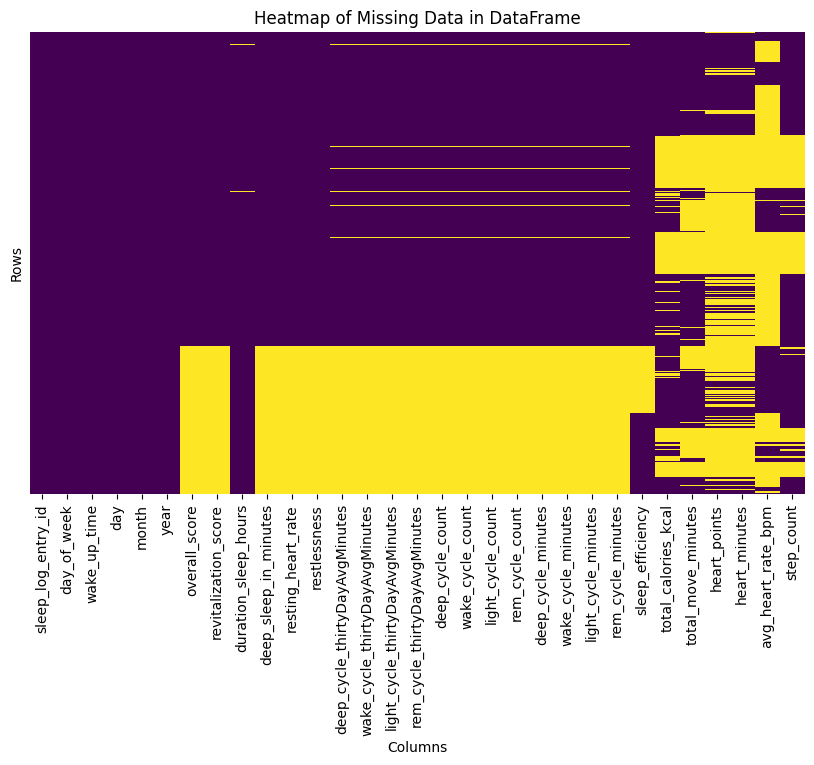

In [51]:
df = pd.read_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\finalised_sleep_metrics.csv')

# created heatmap to visulaize the pattern of missing data
missing_data = df.isna()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')

# Add title and labels as needed
plt.title('Heatmap of Missing Data in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Display the plot
plt.show()

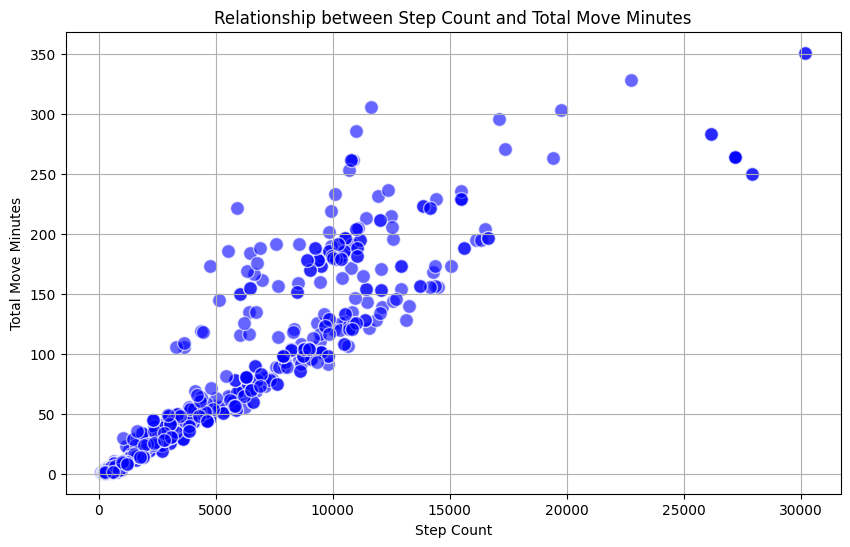

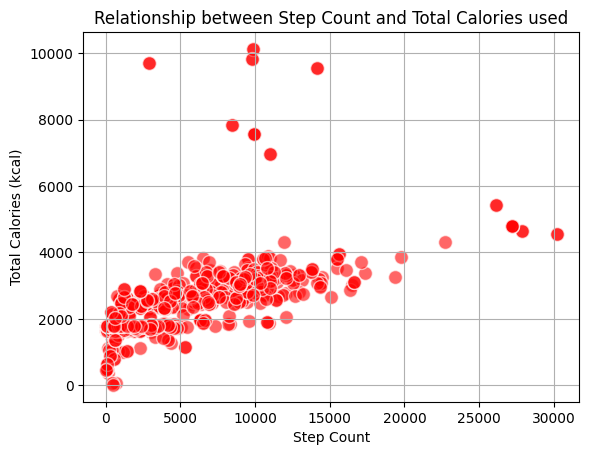

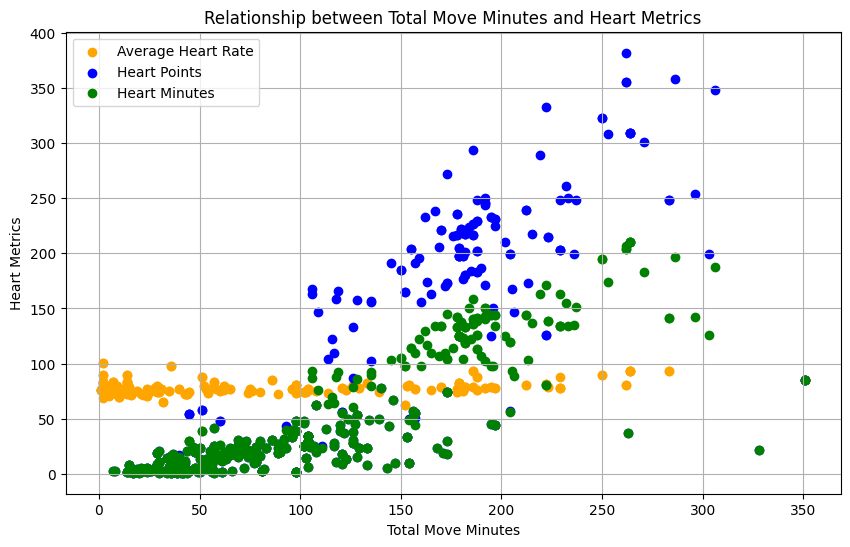

In [18]:
# plot graphs to view if we can perform regression imputation for some missing values

# strong positive correlation - use predictive modelling
plt.figure(figsize=(10, 6))
plt.scatter(df['step_count'], df['total_move_minutes'], alpha=0.6, c='blue', edgecolors='w', s=100)
plt.title('Relationship between Step Count and Total Move Minutes')
plt.xlabel('Step Count')
plt.ylabel('Total Move Minutes')
plt.grid(True)
plt.show()

# weak positive correlation
# Use K-Nearest Neighbors (KNN) algorithm to impute missing values
plt.scatter(df['step_count'], df['total_calories_kcal'], alpha=0.6, c='red', edgecolors='w', s=100)
plt.title('Relationship between Step Count and Total Calories used')
plt.xlabel('Step Count')
plt.ylabel('Total Calories (kcal)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

# Line graph for the relationship between Total Move Minutes and Average Heart Rate
# Can impute missing values for this using mean/median imputation
plt.scatter(df['total_move_minutes'], df['avg_heart_rate_bpm'], label='Average Heart Rate', color='orange')

# Line graph for the relationship between Total Move Minutes and Heart Points
# positive correlation - use predictive modelling
plt.scatter(df['total_move_minutes'], df['heart_points'], label='Heart Points', color='blue')

# Line graph for the relationship between Total Move Minutes and Heart Minutes
# positive correlation - use predictive modelling
plt.scatter(df['total_move_minutes'], df['heart_minutes'], label='Heart Minutes', color='green')

plt.title('Relationship between Total Move Minutes and Heart Metrics')
plt.xlabel('Total Move Minutes')
plt.ylabel('Heart Metrics')
plt.legend()
plt.grid(True)
plt.show()

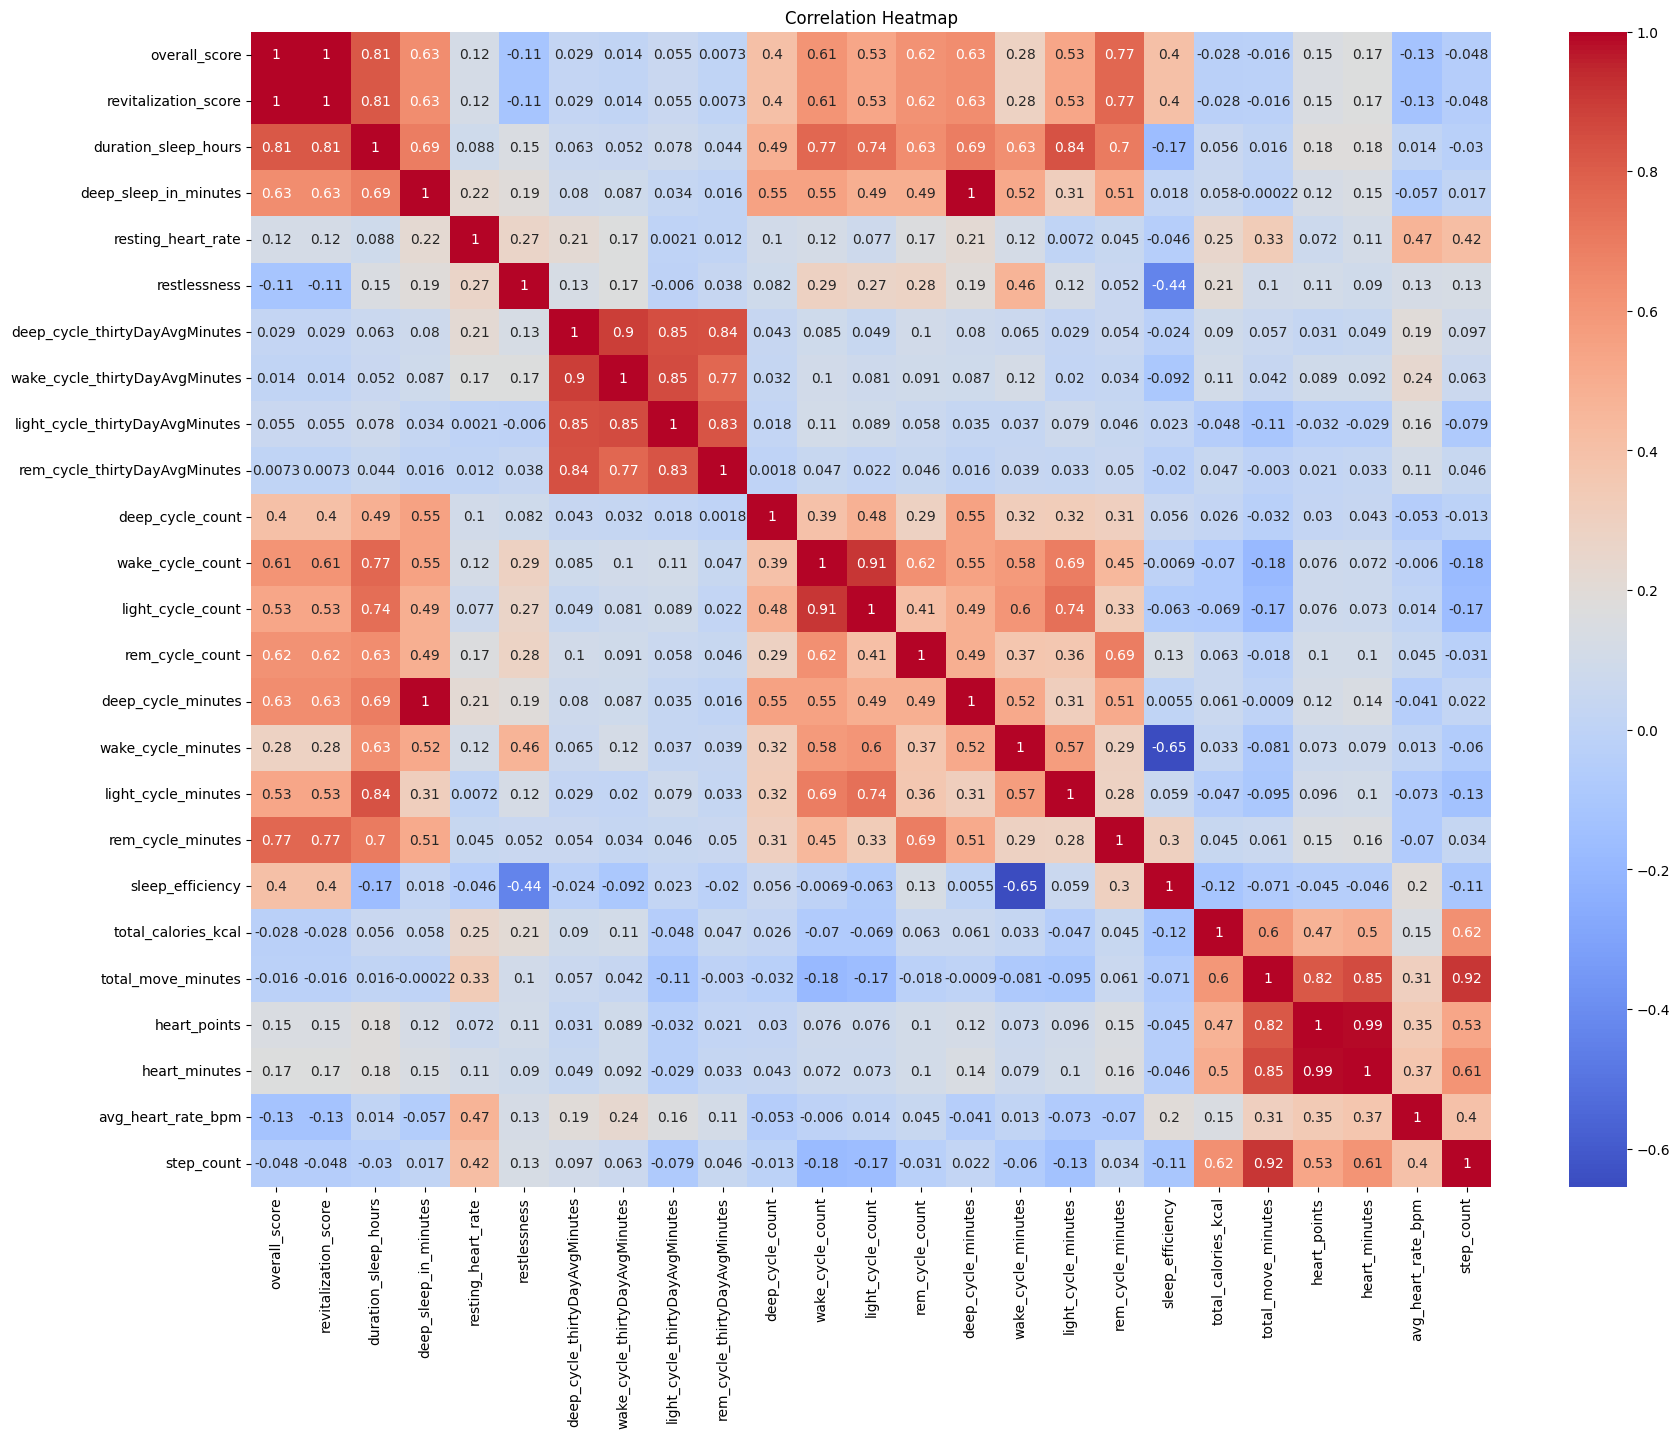

The highly correlated pairs are:
('revitalization_score', 'overall_score')
('duration_sleep_hours', 'overall_score')
('duration_sleep_hours', 'revitalization_score')
('wake_cycle_thirtyDayAvgMinutes', 'deep_cycle_thirtyDayAvgMinutes')
('light_cycle_thirtyDayAvgMinutes', 'deep_cycle_thirtyDayAvgMinutes')
('light_cycle_thirtyDayAvgMinutes', 'wake_cycle_thirtyDayAvgMinutes')
('rem_cycle_thirtyDayAvgMinutes', 'deep_cycle_thirtyDayAvgMinutes')
('rem_cycle_thirtyDayAvgMinutes', 'light_cycle_thirtyDayAvgMinutes')
('light_cycle_count', 'wake_cycle_count')
('deep_cycle_minutes', 'deep_sleep_in_minutes')
('light_cycle_minutes', 'duration_sleep_hours')
('heart_points', 'total_move_minutes')
('heart_minutes', 'total_move_minutes')
('heart_minutes', 'heart_points')
('step_count', 'total_move_minutes')


In [21]:
df2 = pd.read_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\finalised_sleep_metrics.csv')

# set the size of the figure
plt.figure(figsize=(20, 15))

heatmap_columns = ['overall_score', 'revitalization_score', 'duration_sleep_hours', 'deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness', 'deep_cycle_thirtyDayAvgMinutes', 'wake_cycle_thirtyDayAvgMinutes', 'light_cycle_thirtyDayAvgMinutes', 'rem_cycle_thirtyDayAvgMinutes', 'deep_cycle_count', 'wake_cycle_count', 'light_cycle_count', 'rem_cycle_count', 'deep_cycle_minutes', 'wake_cycle_minutes', 'light_cycle_minutes', 'rem_cycle_minutes', 'sleep_efficiency', 'total_calories_kcal', 'total_move_minutes', 'heart_points', 'heart_minutes', 'avg_heart_rate_bpm', 'step_count']

# calculate the correlation matrix
correlation_matrix = df2[heatmap_columns].corr()

# create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# create an empty list to store the highly correlated pairs
highly_correlated_pairs = []

# set the correlation threshold
threshold = 0.8

# iterate over the correlation matrix
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if np.abs(correlation_matrix.iloc[i, j]) > threshold:
            colname1 = correlation_matrix.columns[i]
            colname2 = correlation_matrix.columns[j]
            highly_correlated_pairs.append((colname1, colname2))

# print the highly correlated pairs
print("The highly correlated pairs are:")
for pair in highly_correlated_pairs:
    print(pair)

In [69]:
# Make any cases of variables equal to 0.0 null

file_path = r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\finalised_sleep_metrics.csv'
df = pd.read_csv(file_path)

# List of columns where you want to replace 0.0 with NaN
columns_to_check = ['overall_score', 'revitalization_score', 'duration_sleep_hours', 'deep_sleep_in_minutes', 'resting_heart_rate', 'restlessness', 'deep_cycle_thirtyDayAvgMinutes', 'wake_cycle_thirtyDayAvgMinutes', 'light_cycle_thirtyDayAvgMinutes', 'rem_cycle_thirtyDayAvgMinutes', 'deep_cycle_count', 'wake_cycle_count', 'light_cycle_count', 'rem_cycle_count', 'deep_cycle_minutes', 'wake_cycle_minutes', 'light_cycle_minutes', 'rem_cycle_minutes', 'sleep_efficiency', 'total_calories_kcal', 'total_move_minutes', 'heart_points', 'heart_minutes', 'avg_heart_rate_bpm', 'step_count']

# Replace 0.0 with NaN in specified columns
for column in columns_to_check:
    df[column] = df[column].replace(0.0, pd.NA)

# save the modified DataFrame back to CSV
df.to_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\finalised_sleep_metrics.csv', index=False)

In [70]:
# MICE Imputation

# load the data
file_path = r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\finalised_sleep_metrics.csv'
df = pd.read_csv(file_path)

# Convert wake-up time to seconds past midnight
df['wake_up_time'] = (pd.to_datetime(df['wake_up_time'], format='%H:%M:%S').dt.hour * 3600 +
                      pd.to_datetime(df['wake_up_time'], format='%H:%M:%S').dt.minute * 60 +
                      pd.to_datetime(df['wake_up_time'], format='%H:%M:%S').dt.second)

# define imputer
imputer = IterativeImputer(max_iter=10, tol=0.001, random_state=0)

# apply the imputer to the DataFrame
df_imputed = df.copy()
df_imputed[:] = imputer.fit_transform(df_imputed)

# Convert wake-up time back to time format
df_imputed['wake_up_time'] = pd.to_datetime(df_imputed['wake_up_time'], unit='s').dt.strftime('%H:%M:%S')

# save the imputed DataFrame to a new CSV file
df_imputed.to_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\imputed_finalised_sleep_metrics.csv', index=False)

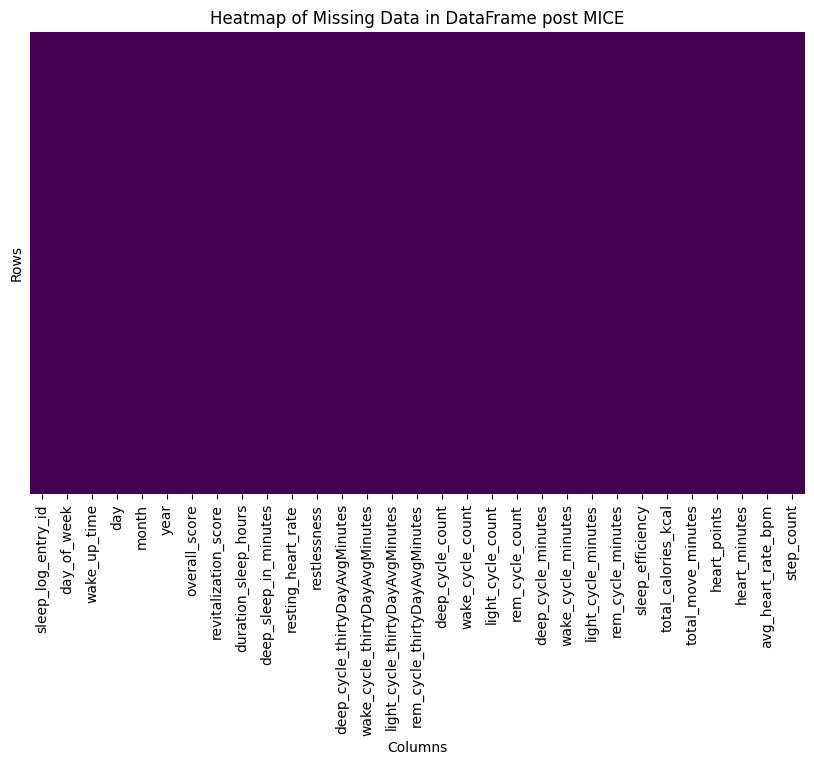

In [73]:
df = pd.read_csv(r'C:\Users\tobic\OneDrive\Desktop\Sleep Predictor Data\imputed_finalised_sleep_metrics.csv')

# created heatmap to visulaize the pattern of missing data
missing_data = df.isna()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data, cbar=False, yticklabels=False, cmap='viridis')

# Add title and labels as needed
plt.title('Heatmap of Missing Data in DataFrame post MICE')
plt.xlabel('Columns')
plt.ylabel('Rows')

# Display the plot
plt.show()

In [ ]:
# check that columns don't have any values that lie outside their ranges

